#### Bibliotecas

In [1]:
from datetime import datetime
from time import time
from contextlib import contextmanager
from typing import List, Union
import pathlib
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,kruskal
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from tsai.all import *
import optuna
from optuna.integration import FastAIPruningCallback

os.environ["DEVICE"] = "cuda"

### Carregando os dados

In [2]:
set_seed(1, False)
@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloc
    
    o de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

In [3]:
with cwd('dados/TrainTestVal_dataset/'):
    y_labels = pd.read_csv('y_labels.csv')['localidade']
    gpp_cax_test,gpp_peru_test,gpp_santarem_test = [pd.read_csv(f'dados_datasetTeste/{x}') for x in sorted(os.listdir('dados_datasetTeste'))]
    X_test,X_train,X_val,y_test,y_train,y_val = [np.load(data) for data in sorted([x for x in os.listdir() if not(x in ['dados_datasetTeste','y_labels.csv',".ipynb_checkpoints"])])]

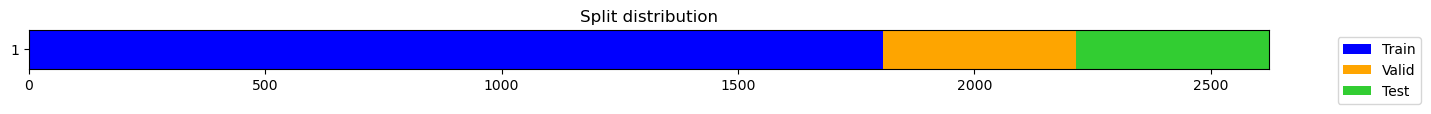

[1806, 408, 408]

In [4]:
X, y, splits = combine_split_data(xs=[X_train, X_val, X_test], ys=[y_train, y_val, y_test])
plot_splits(splits)

tfms = [None, TSForecasting()]
get_splits_len(splits) # [1806, 408, 408] ~= 70%,15%,15%

# Testes com as arquiteturas

In [17]:
archs = [
         XCMPlus,
         ConvTranPlus,
         TSSequencerPlus,      # Arquiteturas que estamos utilizando.
         RNNPlus,              
         ResNetPlus,                            
         InceptionTimePlus,
         TSTPlus,
         TransformerLSTMPlus,
         XceptionTimePlus, 
         TransformerGRUPlus,
         PatchTST,
        ]




def test_archs(epochs):
    for arch in archs:
        print(arch.__name__)
        results = pd.DataFrame(columns=['arch', 'total params', 'train loss', 'valid loss', 'mae_valid','rmse_valid','time','epochs'])
        i=0
        learn = TSForecaster(X, y, splits=splits, path='modelos', tfms=tfms, batch_tfms=TSStandardize(), arch=arch, metrics=[mae,rmse],device=default_device(),loss_func=HuberLoss('mean'))
        start = time.time()
        for epoch in range(1,epochs+1):
            learn.fit_one_cycle(1, lr_max=1e-05)
            if ((epoch % 50) == 0):
                folder_path = f"./modelos/{epochs}_epocas"
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                learn.export(f'{epochs}_epocas/{arch.__name__}.pth')
                elapsed = time.time() - start
                vals = learn.recorder.values[-1]
                results.loc[i] = [arch.__name__, count_parameters(learn.model), vals[0], vals[1], vals[2],vals[3], int(elapsed),epoch]
                results.sort_values(by=['valid loss'], ascending=False, kind='stable', ignore_index=True, inplace=True)
                clear_output()
                display(results)
                i+=1
        results.to_csv(f'./dados/{arch.__name__}_resultados_{epochs}_epocas.csv')

test_archs(400)

,arch,total params,train loss,valid loss,mae_valid,rmse_valid,time,epochs
0,ConvTranPlus,12224,8.343354,8.271259,8.768805,9.206563,17,50
1,ConvTranPlus,12224,7.577115,7.488573,7.985067,8.461625,35,100
2,ConvTranPlus,12224,6.592218,6.493995,6.989096,7.496526,53,150
3,ConvTranPlus,12224,5.514134,5.363947,5.857729,6.395326,71,200
4,ConvTranPlus,12224,4.501830,4.371557,4.862078,5.437578,90,250
5,ConvTranPlus,12224,3.534248,3.404269,3.891708,4.487740,108,300


TSSequencerPlus


epoch,train_loss,valid_loss,mae,_rmse,time
0,9.125962,8.994576,9.494347,9.899691,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,8.842336,8.718331,9.217888,9.630916,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,8.568311,8.439274,8.938467,9.359269,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,8.285095,8.161143,8.659714,9.091817,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,7.995099,7.883317,8.381002,8.823557,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,7.707396,7.606802,8.104352,8.557416,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,7.468073,7.332095,7.830064,8.294110,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,7.174073,7.059442,7.557646,8.032221,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,6.902051,6.791828,7.290170,7.775577,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,6.640650,6.529709,7.027769,7.525324,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,6.378770,6.274750,6.772138,7.281604,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,6.139909,6.026708,6.523294,7.044728,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,5.878364,5.784621,6.280083,6.811584,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,5.642953,5.552612,6.047195,6.588726,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,5.436572,5.331291,5.824584,6.376786,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,5.220975,5.119481,5.611510,6.173417,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,4.997921,4.917150,5.408461,5.976990,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,4.794503,4.725356,5.216002,5.789962,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,4.623964,4.542939,5.032622,5.612091,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,4.440860,4.370952,4.860020,5.443150,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,4.268373,4.208332,4.696949,5.282438,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,4.108552,4.055820,4.544096,5.130758,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,3.976982,3.913751,4.401862,4.989252,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,3.835547,3.778328,4.266475,4.854446,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,3.687334,3.652345,4.140163,4.727643,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,3.588937,3.533820,4.021152,4.608086,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,3.452773,3.421118,3.907939,4.493717,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,3.349879,3.316762,3.803077,4.388527,00:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,3.234407,3.218655,3.704726,4.288270,00:02


epoch,train_loss,valid_loss,mae,_rmse,time


KeyboardInterrupt: 

# Otimização do modelo selecionado com o Optuna

In [ ]:
def objective_Xception(trial):
    
    nf = trial.suggest_int('nf', 16, 384)
    adaptive_size = trial.suggest_int('adaptive_size', 10, 200)

    arch_config = {
        'nf': nf,
        'adaptive_size': adaptive_size,
    }

    learning_rate_model = trial.suggest_float("learning_rate_model", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    Huber_delta = trial.suggest_float("Huber_delta", 1, 2)
    
    standardize_sample = trial.suggest_categorical('by_sample', [True, False])
    standardize_var = trial.suggest_categorical('by_var', [True, False])

    arch = XceptionTimePlus

    learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms,
                        batch_tfms=TSStandardize(by_sample=standardize_sample, by_var=standardize_var),arch=arch,
                        arch_config= arch_config, metrics=[rmse], cbs=FastAIPruningCallback(trial), device=device,
                        loss_func=HuberLoss('mean',Huber_delta),seed=1)
    
    with ContextManagers([learn.no_bar(),learn.no_logging()]):
            learn.fit_one_cycle(200, lr_max=learning_rate_model)
            intermediate_value = learn.recorder.values[-1][-1]

    folder_path = "./optuna_tests/XceptionPlus/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    file_path = os.path.join(folder_path, "{}.pickle".format(trial.number))
    if os.path.exists(file_path):
        os.remove(file_path)

    # Salva o novo arquivo
    with open(file_path, "wb") as fout:
        pickle.dump(learn, fout)

    return intermediate_value


study_xc = run_optuna_study(objective_Xception,sampler= optuna.samplers.TPESampler(n_startup_trials=250,seed=1),n_trials=1000,gc_after_trial=True,direction="minimize",show_plots=False)

print(f"O Melhor modelo foi o de número {study_xc.best_trial.number}")

epoch,train_loss,valid_loss,mae,_rmse,time
0,8.666117,8.618976,9.118955,9.460961,00:01
1,8.553072,8.411018,8.910787,9.237691,00:01
2,8.415347,8.178560,8.678104,9.007480,00:01
3,8.234340,7.897465,8.396156,8.727654,00:01
4,7.969855,7.442861,7.940866,8.279634,00:01
5,7.630875,6.916366,7.414494,7.783615,00:01
6,7.119339,6.044441,6.540518,6.972138,00:01
7,6.309294,4.681493,5.172413,5.666988,00:01
8,4.992583,2.659012,3.135917,3.782756,00:01
9,3.658629,1.782267,2.243387,2.852366,00:01


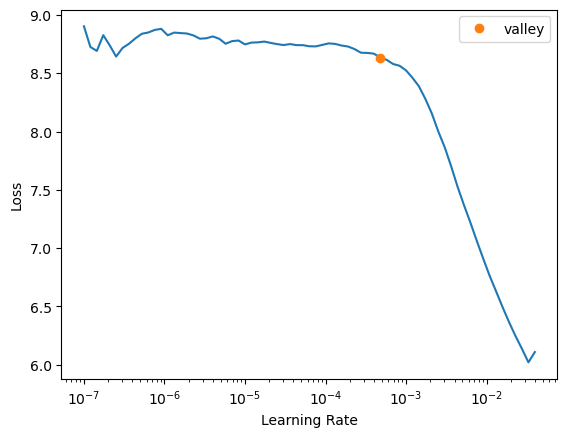

In [20]:
learner = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=TSStandardize(), arch=XceptionTimePlus, metrics=[mae,rmse],device=default_device(),loss_func=HuberLoss('mean'))
lr = learner.lr_find() # learning rate find
learner.fit_one_cycle(150, lr_max=lr.valley)

# Avaliação do Melhor Modelo

In [ ]:
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath


with open(f"./melhor_modelo_optuna/{805}.pickle", "rb") as fin:
    learner = pickle.load(fin)

In [34]:
raw_preds, target, preds = learner.get_X_preds(X[splits[2]], y[splits[2]])

In [35]:
preds_df = pd.concat([pd.DataFrame(raw_preds),y_labels.to_frame()],axis=1)
target_df = pd.concat([pd.DataFrame(y_test),y_labels.to_frame()],axis=1)

dfs_preds = {}
dfs_target = {}

for localidade in preds_df['localidade'].unique():
    dfs_preds[localidade] = preds_df[preds_df['localidade'] == localidade]

for localidade in target_df['localidade'].unique():
    dfs_target[localidade] = target_df[target_df['localidade'] == localidade]

# Acessando os DataFrames separados

df_peru_pred = dfs_preds['peru'].drop('localidade',axis=1)
df_santarem_pred = dfs_preds['santarem'].drop('localidade',axis=1)
df_caxiuana_pred = dfs_preds['caxiuana'].drop('localidade',axis=1)

df_peru_target = dfs_target['peru'].drop('localidade',axis=1)
df_santarem_target = dfs_target['santarem'].drop('localidade',axis=1)
df_caxiuana_target = dfs_target['caxiuana'].drop('localidade',axis=1)

In [46]:
datas_conj_teste = gpp_peru_test.loc[gpp_peru_test['peru'].isin(y[splits[2]].flatten())]['index']
datas_conj_teste = pd.to_datetime(datas_conj_teste)

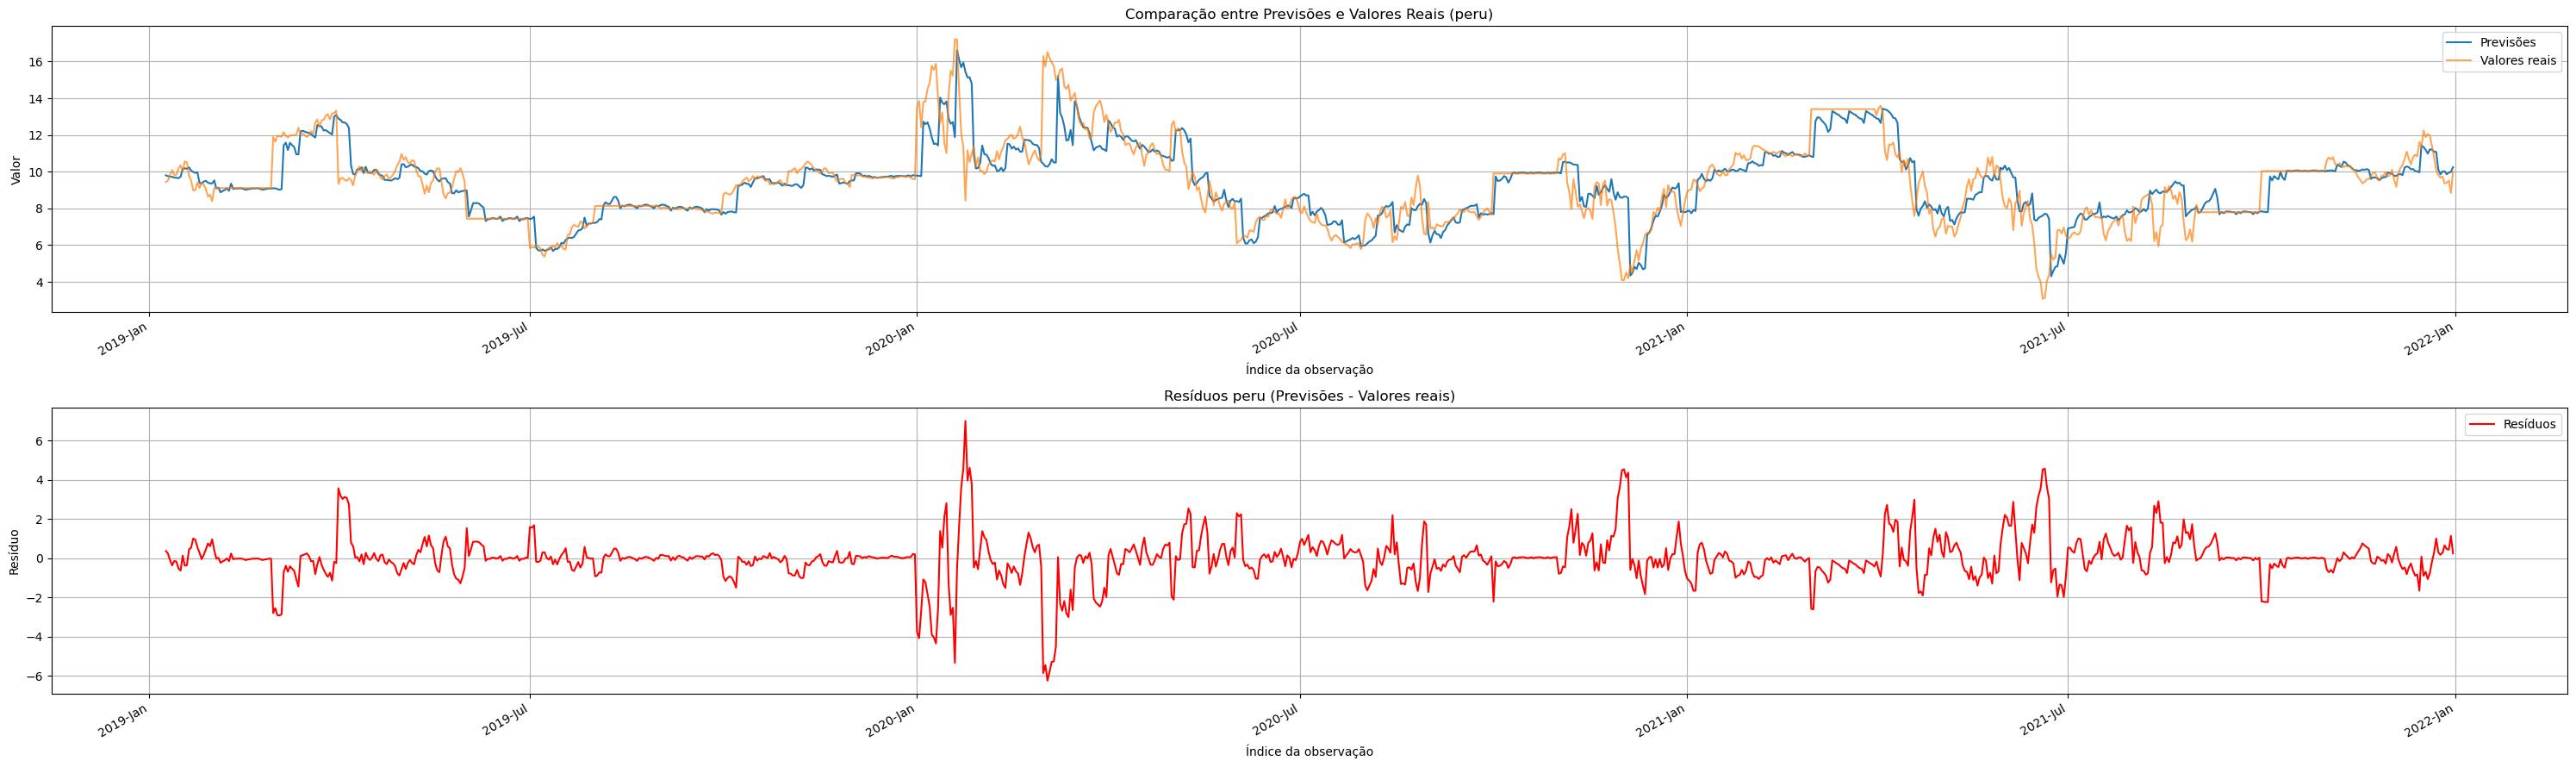

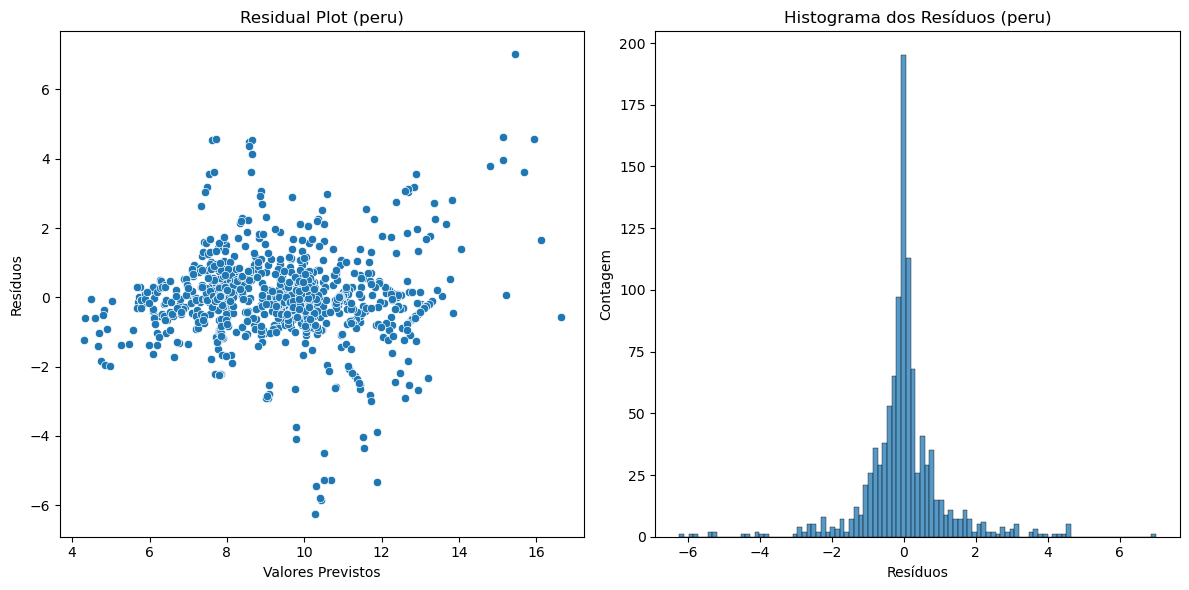

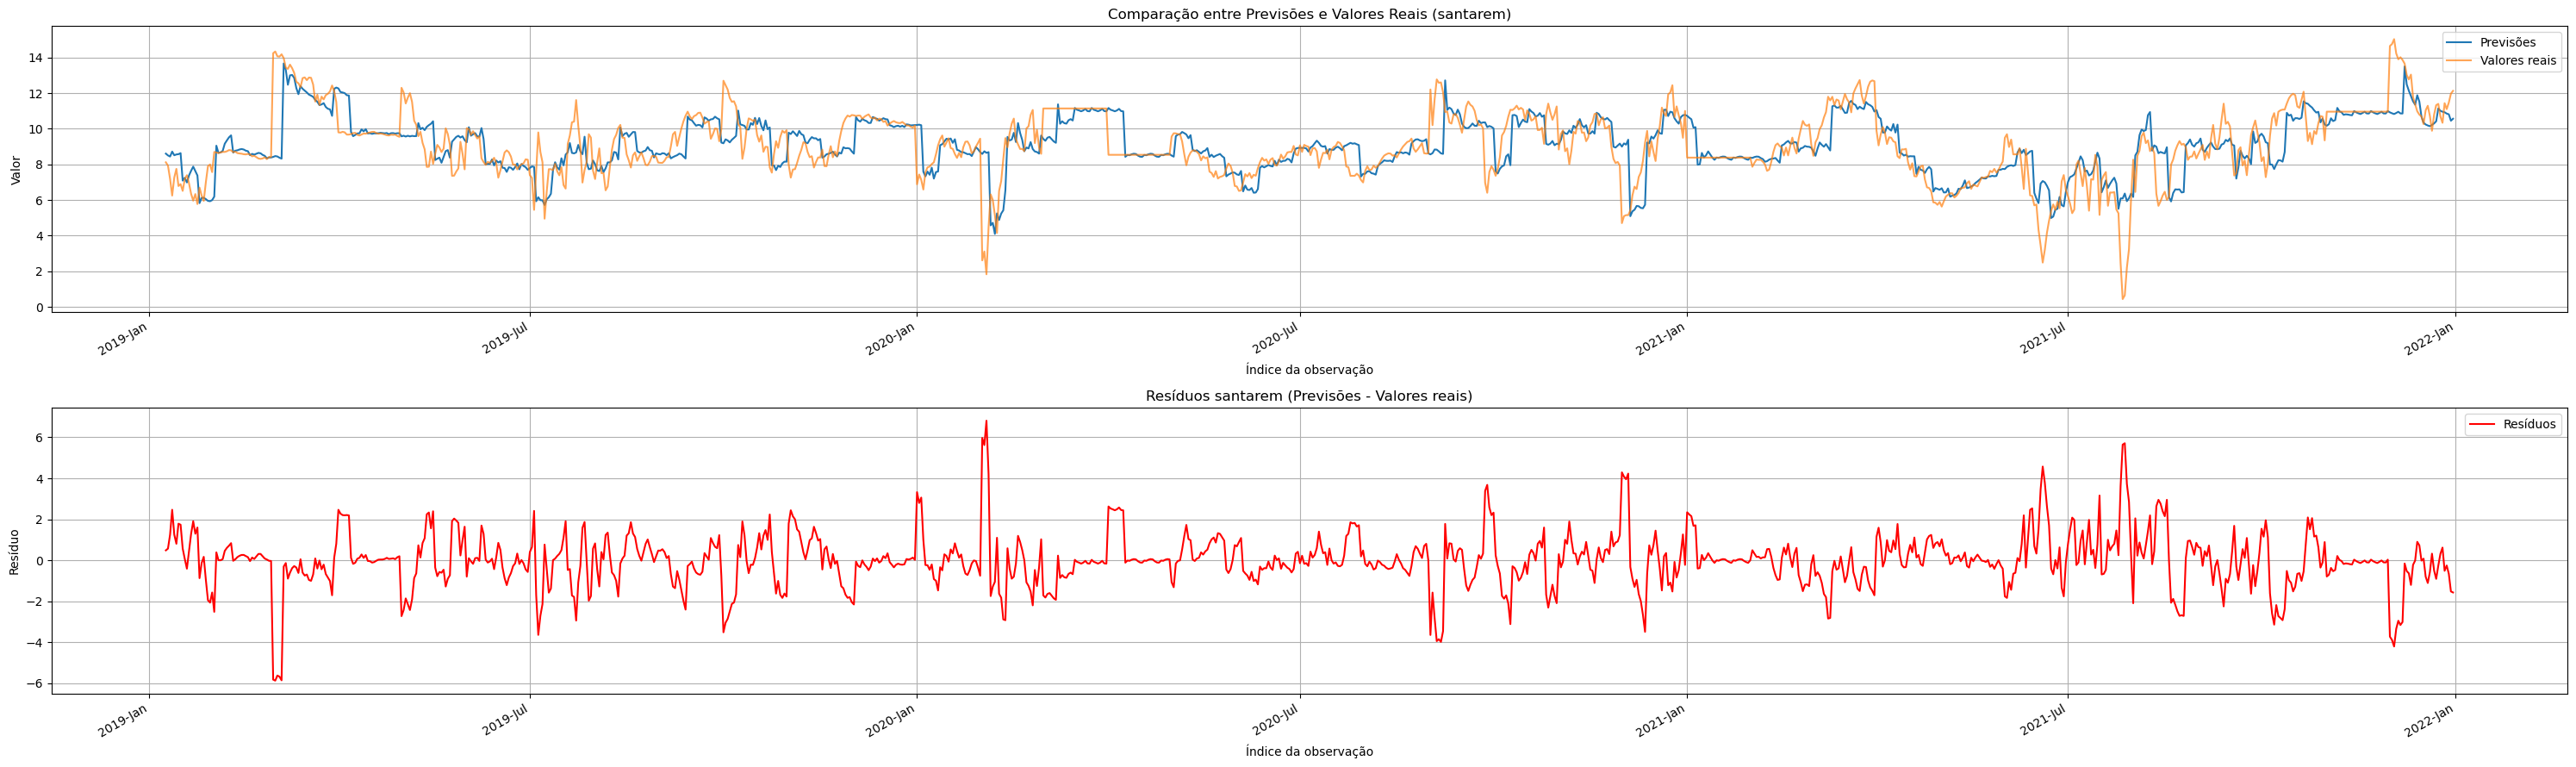

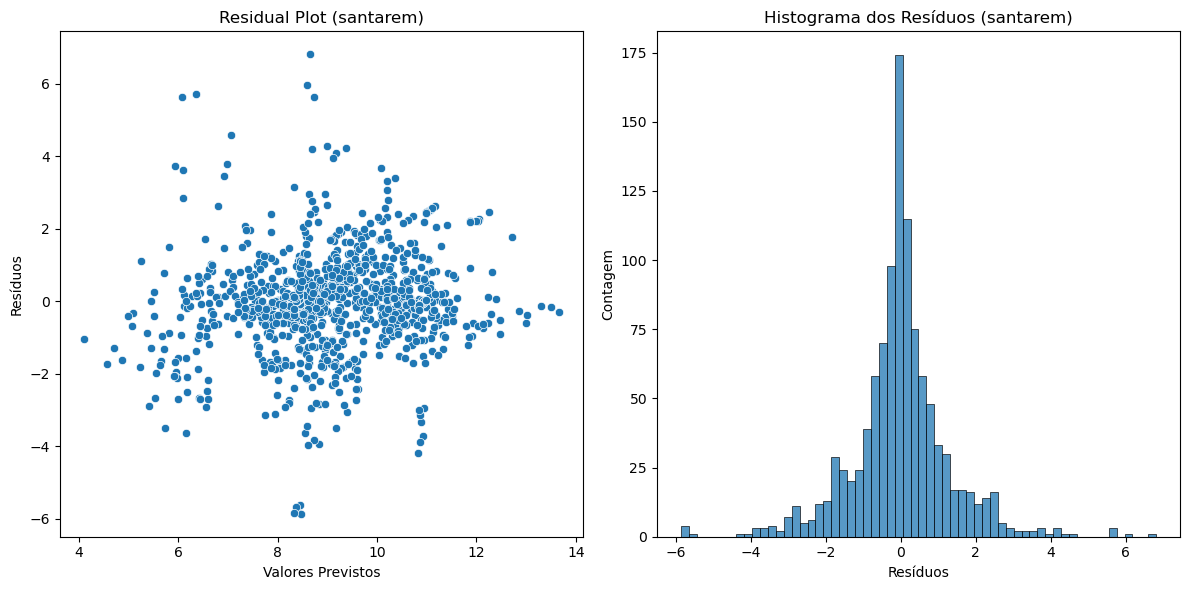

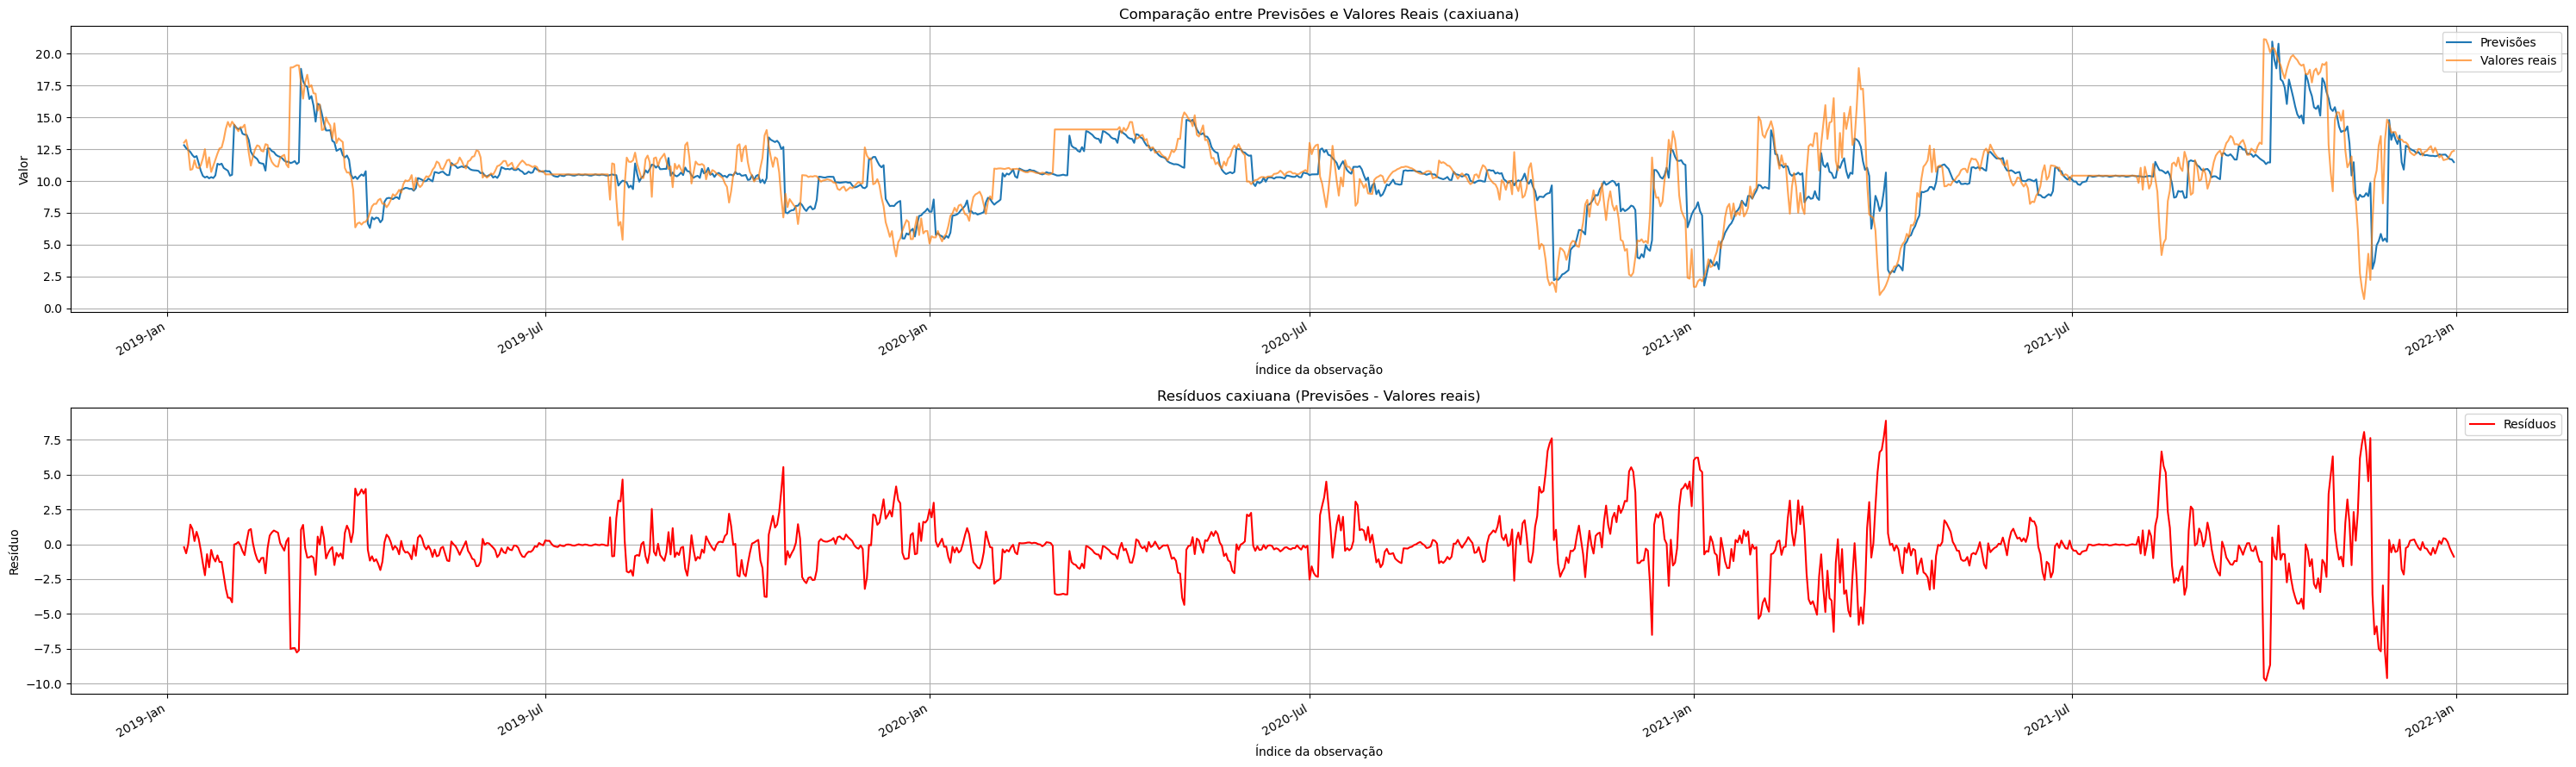

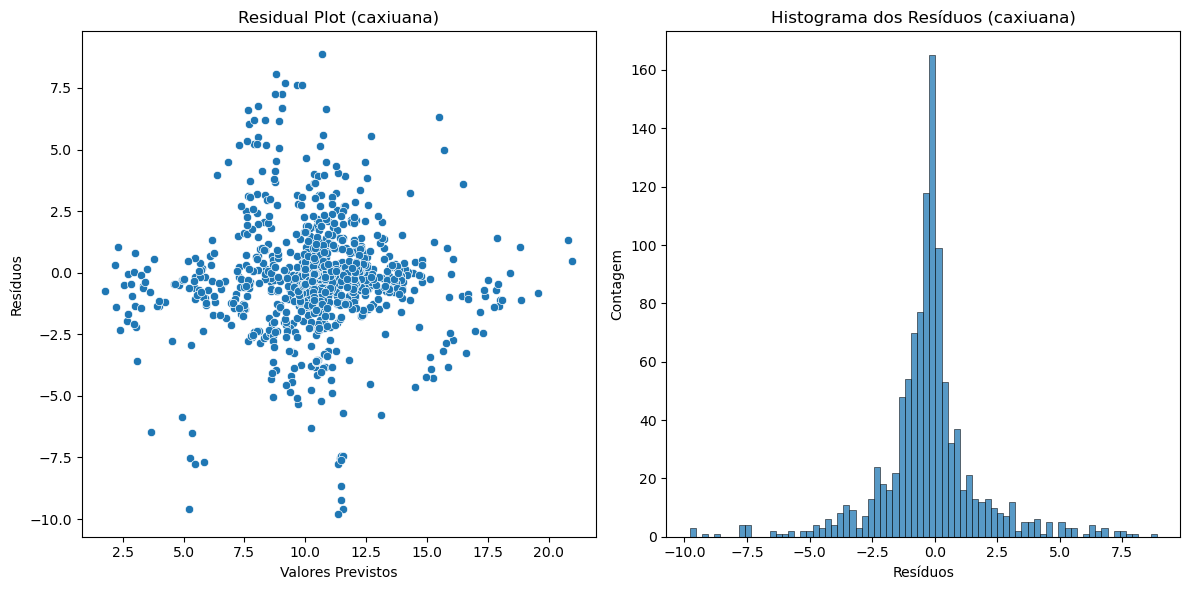

In [47]:
import matplotlib.dates as mdates

def get_summary(df_pred,df_target):
    results = {}
    for i in dfs_preds:
        mae_test = mean_absolute_error(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
        mse_test = mean_squared_error(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
        results[i] = [r2_test,mae_test,rmse_test,np.corrcoef(df_pred[i].drop('localidade',axis=1).values.flatten(), df_target[i].drop('localidade',axis=1).values.flatten())[0][1]]

        residuos = df_pred[i].drop('localidade',axis=1).values - df_target[i].drop('localidade',axis=1).values
        plt.figure(figsize=(30, 9))
        plt.subplot(2, 1, 1)

        plt.plot(datas_conj_teste, df_pred[i].drop('localidade',axis=1).values.flatten(), label='Previsões', alpha=1)
        plt.plot(datas_conj_teste, df_target[i].drop('localidade',axis=1).values.flatten(), label='Valores reais', alpha=0.7)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        for label in plt.gca().get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')

        plt.xlabel('Índice da observação')
        plt.ylabel('Valor')
        plt.title(f'Comparação entre Previsões e Valores Reais ({i})')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.plot(datas_conj_teste,residuos.flatten(), label='Resíduos', color='red')

        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        for label in plt.gca().get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')

        plt.xlabel('Índice da observação')
        plt.ylabel('Resíduo')
        plt.title(f'Resíduos {i} (Previsões - Valores reais)')
        plt.legend()
        plt.grid(True)

        # Seu código para mostrar os gráficos
        plt.tight_layout()
        plt.show()

        residuos_flatten = residuos.flatten()

        # Criar figura e eixos para o subplot
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot do residual plot
        sns.scatterplot(x=df_pred[i].drop('localidade',axis=1).values.flatten(), y=residuos_flatten, ax=axes[0])
        axes[0].set_title(f'Residual Plot ({i})')
        axes[0].set_xlabel('Valores Previstos')
        axes[0].set_ylabel('Resíduos')

        # Plot do histograma dos resíduos
        sns.histplot(residuos_flatten, ax=axes[1])
        axes[1].set_title(f'Histograma dos Resíduos ({i})')
        axes[1].set_xlabel('Resíduos')
        axes[1].set_ylabel('Contagem')

        # Ajuste o layout
        plt.tight_layout()
        plt.show()


    return pd.DataFrame(results,index=['R²','MAE','RMSE','Corr'])

df_regioes = get_summary(dfs_preds,dfs_target)

In [48]:
mae_geral = mean_absolute_error(raw_preds,target)
mse_geral = mean_squared_error(raw_preds,target)
rmse_geral = np.sqrt(mse_geral)
r2_geral = r2_score(y_pred=raw_preds,y_true=target)

resultados_geral = {}
resultados_geral['Geral'] = [r2_geral,mae_geral,mse_geral,np.corrcoef(raw_preds.flatten(), target.flatten())[0][1]]
resultados_geral = pd.DataFrame(resultados_geral,index=df_regioes.index)

df_geral = pd.concat([df_regioes,resultados_geral],axis=1)
display(df_geral)

,peru,santarem,caxiuana,Geral
R²,0.716499,0.505157,0.590337,0.634662
MAE,0.677601,0.885706,1.296074,0.953127
RMSE,1.146655,1.327284,2.072552,2.457324
Corr,0.846474,0.711202,0.769185,0.794772
